In [2]:
import pandas as pd
from textblob import TextBlob
import glob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

### Load datasets

In [3]:
all_files = glob.glob("./dataset_cleaning/*.pkl")
test_filename= "./dataset_cleaning/dataset2Cleaned.pkl"
li = []

for filename in all_files:
    
    if(filename != test_filename):

        df = pd.read_pickle(filename)
        li.append(df)

train_df = pd.concat(li, axis=0, ignore_index=True)
test_df = pd.read_pickle(test_filename)

print("Number of train features: {} \nNumber of test features: {}".format(len(train_df), len(test_df)))

Number of train features: 49408 
Number of test features: 15738


In [4]:
train_df.head()

,Informativeness,text
0,0,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...
1,0,Get in on the fun every Thursday with the @csi...
2,0,Welcome to our newest STUDENTathlete- Reagan B...
3,0,Denver Post: #Colorado governor signs bill cre...
4,0,Pretty sure I'm going to live in Manitou Sprin...


In [5]:
test_df.head()

,Informativeness,text
0,1,RT @Gizmodo: Wildfires raging through Northern...
1,1,PHOTOS: Deadly wildfires rage in California ht...
2,1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...
4,1,RT @TIME: California's raging wildfires as you...
5,1,Wildfires Threaten Californiaâ€™s First Legal ...


In [6]:
train_df["Informativeness"].value_counts()

1    34583
0    14825
Name: Informativeness, dtype: int64

In [7]:
test_df["Informativeness"].value_counts()

1    11357
0     4381
Name: Informativeness, dtype: int64

In [8]:
train_df.drop_duplicates(subset=["text"], keep="first", inplace=True)
test_df.drop_duplicates(subset=["text"], keep="first", inplace=True)

### Process the text

In [9]:

def text_processing(tweet):
    
    tweet= tweet.lower()
    
    #Removing hyperlinks from the tweet
    tweet_no_links=re.sub(r'http\S+', '', tweet)
    
    #Generating the list of words in the tweet (hashtags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet_no_links)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return " ".join(normalized_tweet)
    
    
    return normalization(no_punc_tweet)

In [10]:
train_df['text_processed']=train_df['text'].apply(text_processing)

In [11]:
test_df['text_processed']=test_df['text'].apply(text_processing)

In [12]:
pd.set_option('display.max_colwidth', -1)
train_df.iloc[3]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


Informativeness    0                                                                                                                   
text               Denver Post: #Colorado governor signs bill creating rules for public access to ballots http://t.co/Hmp1wQ8P #opengov
text_processed     denver post colorado governor sign bill create rule public access ballot opengov                                    
Name: 3, dtype: object

In [13]:
#Randomise order of train dataset
train_df = sklearn.utils.shuffle(train_df)

## Baseline model

Split data into X and Y, as well as train/test sets

In [14]:
# from sklearn.model_selection import train_test_split



# sentences = main_df['text'].values
# y = main_df['Informativeness'].values

# sentences_train, sentences_test, y_train, y_test = train_test_split(
#    sentences, y, test_size=0.25, random_state=1000)


In [15]:
sentences_train = train_df['text_processed'].values
sentences_test = test_df['text_processed'].values

y_train = train_df['Informativeness'].values
y_test = test_df['Informativeness'].values




In [16]:
sentences_train

array(['engineer daydream crash new york daily news',
       'rt meher_j afp uno unesco unicef shame pak govt earthquake effectees surround dco offc awaran people cry',
       'rt let pray chile prayforchile lt', ..., 'fuck place laxshooting',
       'rt ebola patient commercial flight night report symptoms fever',
       'colombia president duque announce march nationwide isolation measure would effect tuesday march april measure intend slow spread coronavirus colombia traveladvice'],
      dtype=object)

Vectorize sentances using CountVectorizer

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Vevotize each sentance
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

# Too look at the vocabulary encoding
# vectorizer.vocabulary_

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [43]:

# {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])}

Evaluate using Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.696403609098996


In [18]:
y_pred = classifier.predict(X_test)
y_pred_prob=classifier.predict_proba(X_test)[:,1]

precision_LR = precision_score(y_test, y_pred)
recall_LR = recall_score(y_test, y_pred)
f1_LR= f1_score(y_test, y_pred)
roc_LR = roc_auc_score(y_test, y_pred_prob)

fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_pred_prob)

print("Precision: {} \nRecall:{} \nF1 Score: {} \nAUC: {}".format(precision_LR, recall_LR, f1_LR, roc_LR))

Precision: 0.8345367639581003 
Recall:0.7225499691820023 
F1 Score: 0.7745162812647475 
AUC: 0.7398428082136923


# Using embeddings (Glove)

In [19]:
# This time don't vectorize, but tokenize. Same idea but runs better with Keras and tokenizer assings
# index 1 to most frequent word and so on. While vecotrizer makes each sentcance to a vector of the same
# size (the vocabulary size) and assigns count of how many time a word appears

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[1])
print(X_train[1])



oh hear joe diffie announce coronavirus friday pass away today
[580, 218, 1980, 206, 4, 308, 348, 301, 28]


In [20]:
# Pad with trailing 0 every tokenized sentance so that they have the same length (the length of the longest sentance)

from keras.preprocessing.sequence import pad_sequences

maxlen = len(max(X_train, key=len)) #length of the longest sentance

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[3220  648 2547 2066  201 2548 1556    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [21]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

Load pretrained data

In [22]:
# Download here: https://nlp.stanford.edu/projects/glove/

embedding_dim = 300
embedding_matrix = create_embedding_matrix(
    'glove_data/glove.6B.300d.txt',
    tokenizer.word_index, embedding_dim)



Percantage of vocabulary covered in the pretrained model

In [23]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.5506530883329643

In [24]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 417, 300)          13551000  
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                3010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 13,554,021
Trainable params: 3,021
Non-trainable params: 13,551,000
_________________________________________________________________


In [25]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {}".format(accuracy))
# plot_history(history)

Epoch 1/30
4935/4935 [==============================] - 15s 3ms/step - loss: 0.4708 - accuracy: 0.7740 - val_loss: 0.5164 - val_accuracy: 0.7531
Epoch 2/30
4935/4935 [==============================] - 17s 3ms/step - loss: 0.4373 - accuracy: 0.7927 - val_loss: 0.5240 - val_accuracy: 0.7500
Epoch 3/30
4935/4935 [==============================] - 15s 3ms/step - loss: 0.4270 - accuracy: 0.7962 - val_loss: 0.5122 - val_accuracy: 0.7536
Epoch 4/30
4935/4935 [==============================] - 15s 3ms/step - loss: 0.4197 - accuracy: 0.8027 - val_loss: 0.5096 - val_accuracy: 0.7542
Epoch 5/30
4935/4935 [==============================] - 15s 3ms/step - loss: 0.4147 - accuracy: 0.8065 - val_loss: 0.5294 - val_accuracy: 0.7488
Epoch 6/30
4935/4935 [==============================] - 15s 3ms/step - loss: 0.4088 - accuracy: 0.8072 - val_loss: 0.5073 - val_accuracy: 0.7558
Epoch 7/30
4935/4935 [==============================] - 15s 3ms/step - loss: 0.4036 - accuracy: 0.8132 - val_loss: 0.5244 - val_ac

In [26]:
y_pred =(model.predict(X_test) > 0.5).astype("int32")
y_pred_prob = model.predict(X_test)

precision_Glove_Untrainable = precision_score(y_test, y_pred)
recall_Glove_Untrainable = recall_score(y_test, y_pred)
f1_Glove_Untrainable= f1_score(y_test, y_pred)
roc_Glove_Untrainable = roc_auc_score(y_test, y_pred_prob)

fpr_Glove_Untrainable, tpr_Glove_Untrainable, thresholds_Glove_Untrainable = roc_curve(y_test, y_pred_prob)

print("Precision: {} \nRecall:{} \nF1 Score: {} \nAUC: {}".format(precision_Glove_Untrainable, recall_Glove_Untrainable, f1_Glove_Untrainable, roc_Glove_Untrainable))


Precision: 0.8122285912801807 
Recall:0.823456898828916 
F1 Score: 0.8178042061999913 
AUC: 0.7482949508388269


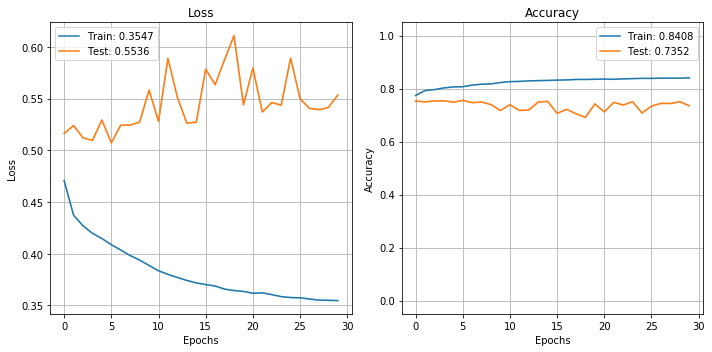

In [27]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt


plot_history(history.history)
plt.show()
plt.close()

### Do the same thing with glove, but this time all parameters are trainable (takes much longer to run)

In [28]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 417, 300)          13551000  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 13,554,021
Trainable params: 13,554,021
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
4935/4935 [==============================] - 594s 120ms/step - loss: 0.3853 - accuracy: 0.8233 - val_loss: 0.5129 - val_accuracy: 0.7559
Epoch 2/20
4935/4935 [==============================] - 589s 119ms/step - loss: 0.2742 - accuracy: 0.8856 - val_loss: 0.5472 - val_accuracy: 0.7373
Epoch 3/20
4935/4935 [==============================] - 588s 119ms/step - loss: 0.2097 - accuracy: 0.9145 - val_loss: 0.6779 - val_accuracy: 0.6957
Epoch 4/20
4935/4935 [==============================] - 589s 119ms/step - loss: 0.1491 - accuracy: 0.9442 - val_loss: 0.7604 - val_accuracy: 0.7033
Epoch 5/20
4935/4935 [==============================] - 588s 119ms/step - loss: 0.0974 - accuracy: 0.9639 - val_loss: 0.9591 - val_accuracy: 0.7039
Epoch 6/20
4935/4935 [==============================] - 593s 120ms/step - loss: 0.0604 - accuracy: 0.9784 - val_loss: 1.1103 - val_accuracy: 0.7163
Epoch 7/20
4935/4935 [==============================] - 590s 119ms/step - loss: 0.0392 - accuracy: 0.9858 - val_

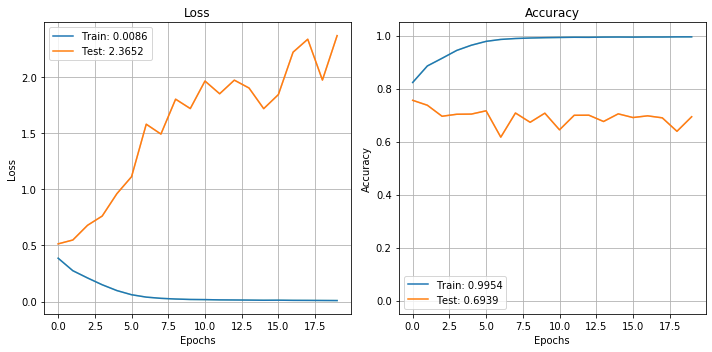

In [29]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {}".format(accuracy))
plot_history(history.history)

In [30]:
y_pred =(model.predict(X_test) > 0.5).astype("int32")
y_pred_prob = model.predict(X_test)

precision_Glove = precision_score(y_test, y_pred)
recall_Glove = recall_score(y_test, y_pred)
f1_Glove = f1_score(y_test, y_pred)
roc_Glove = roc_auc_score(y_test, y_pred_prob)

fpr_Glove, tpr_Glove, thresholds_Glove= roc_curve(y_test, y_pred_prob)

print("Precision: {} \nRecall:{} \nF1 Score: {} \nAUC: {}".format(precision_Glove, recall_Glove, f1_Glove, roc_Glove))


Precision: 0.7945230159445095 
Recall:0.7766135423087083 
F1 Score: 0.7854662035800161 
AUC: 0.6877936651091889


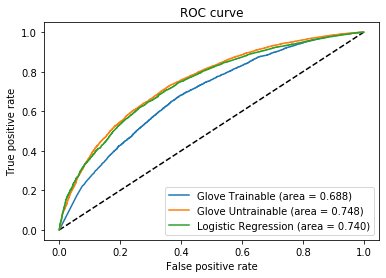

In [31]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Glove, tpr_Glove, label='Glove Trainable (area = {:.3f})'.format(roc_Glove))
plt.plot(fpr_Glove_Untrainable, tpr_Glove_Untrainable, label='Glove Untrainable (area = {:.3f})'.format(roc_Glove_Untrainable))
plt.plot(fpr_LR, tpr_LR, label='Logistic Regression (area = {:.3f})'.format(roc_LR))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()